In [20]:
from sena.data.norec_sentence.dataloader import load_binary_dataset
import sena.utils.preprocessing as preprocessing
import pandas as pd

In [21]:
data = load_binary_dataset()

train = data["train"]
val = data["dev"]
test = data["test"]

train = preprocessing.clean_text(train, "text")
val = preprocessing.clean_text(val, "text")
test = preprocessing.clean_text(test, "text")

combined_data = pd.concat([train, val, test])

In [22]:
from collections import Counter
import math

num_words = Counter()
for review in combined_data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
num_words = math.ceil(num_words / 1000) * 1000
print("Number of words:", num_words)

Number of words: 17000


<AxesSubplot:>

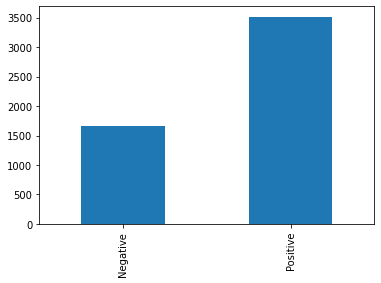

In [23]:
combined_data["label"].replace({0: "Negative", 1: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

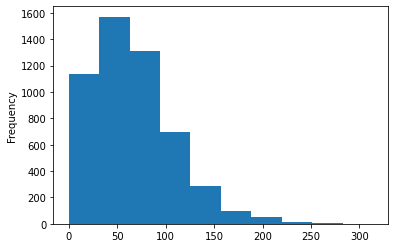

In [24]:
combined_data["text"].str.len().plot.hist()

In [25]:
from keras.preprocessing.text import Tokenizer

X_train, y_train = train["text"], train["label"]
X_val, y_val = val["text"], val["label"]
X_test, y_test = test["text"], test["label"]

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(combined_data["text"])

X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(X_test)

In [26]:
from collections import Counter

combined_text = tokenizer.texts_to_sequences(combined_data["text"])

word_counter = Counter()
for review in combined_text:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [27]:
word_counter.most_common(10)

[('litt', 200),
 ('godt', 178),
 ('gjør', 172),
 ('får', 163),
 ('the', 144),
 ('filmen', 141),
 ('helt', 139),
 ('nok', 134),
 ('to', 125),
 ('hele', 118)]

In [28]:
from keras_preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

maxlen = 100
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape, end="\n\n")
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape, end="\n\n")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3894, 100)
y_train shape: (3894, 2)

X_val shape: (701, 100)
y_val shape: (701, 2)

X_test shape: (583, 100)
y_test shape: (583, 2)


In [10]:
from sena.utils.embeddings import load_embeddings

embeddings_index = load_embeddings()

Loading embeddings: 100%|██████████| 4031461/4031461 [03:38<00:00, 18485.65it/s]


In [29]:
import numpy as np

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [30]:
from keras import Input
from keras.layers import Embedding, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Input(shape=(embedding_dim,), dtype="float32"))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(2, activation="softmax"))

In [31]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          1691700   
                                                                 
 input_3 (InputLayer)        multiple                  0         
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_6 (Dense)             (None, 100)               1000100   
                                                                 
 dense_7 (Dense)             (None, 32)                3232      
                                                                 
 dense_8 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2,695,098
Trainable params: 1,003,398
No

In [32]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 50
batch_size = 16

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
244/244 [==============================] - 4s 8ms/step - loss: 0.6196 - accuracy: 0.6713 - val_loss: 0.5835 - val_accuracy: 0.7004
Epoch 2/50
244/244 [==============================] - 2s 7ms/step - loss: 0.5173 - accuracy: 0.7304 - val_loss: 0.5852 - val_accuracy: 0.7033
Epoch 3/50
244/244 [==============================] - 2s 7ms/step - loss: 0.3926 - accuracy: 0.8187 - val_loss: 0.6562 - val_accuracy: 0.6833
Epoch 4/50
244/244 [==============================] - 2s 7ms/step - loss: 0.2379 - accuracy: 0.9027 - val_loss: 0.7854 - val_accuracy: 0.6847
Epoch 5/50
244/244 [==============================] - 2s 7ms/step - loss: 0.1295 - accuracy: 0.9551 - val_loss: 0.9719 - val_accuracy: 0.6505


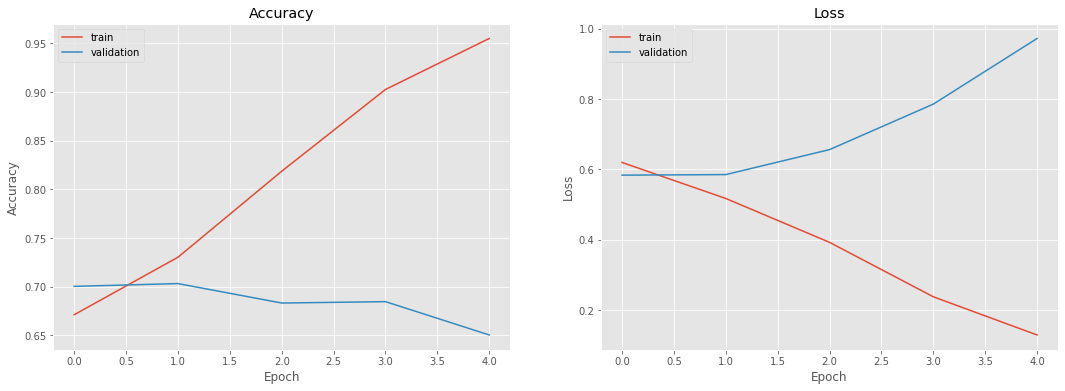

In [33]:
from sena.utils.visualization import plot_history

plot_history(history)

In [34]:
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

19/19 [==============================] - 0s 4ms/step - loss: 1.0871 - accuracy: 0.6415
Validation loss: 1.0870569944381714
Validation accuracy: 0.6415094137191772


In [35]:
from datetime import datetime

if val_acc > 0.8:
    model.save(f"models/SA-GLOVE-BINARY-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")